In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
import math
import subprocess, os
from copy import deepcopy
import probscale
import matplotlib
import matplotlib.gridspec as gridspec
from osgeo import gdal
import rasterio
from rasterio.plot import show
from numpy import median

In [64]:
#function to export as EMF by using Inkscape: found at https://stackoverflow.com/questions/9266150/matplotlib-generating-vector-plot 
def plot_as_emf(figure, **kwargs):
    inkscape_path = kwargs.get('inkscape', "C://Program Files//Inkscape//inkscape.exe")
    filepath = kwargs.get('filename', None)

    if filepath is not None:
        path, filename = os.path.split(filepath)
        filename, extension = os.path.splitext(filename)

        svg_filepath = os.path.join(path, filename+'.svg')
        emf_filepath = os.path.join(path, filename+'.emf')

        figure.savefig(svg_filepath, format='svg', bbox_inches = 'tight')

        subprocess.call([inkscape_path, svg_filepath, '--export-emf', emf_filepath])
        os.remove(svg_filepath)
        
#Sample usage: plot_as_emf(f, filename="Output.emf")

Below script was created for multiple PCA outputs. I do not want to spoil my script in order to be able to use in the future. That is why I only edited some parts, and there are parts that looks unneccessarily long.

In [65]:
#Pandas dataframe settings

#display format of decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#remove display limitation of rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [66]:
# get the files in the directory with PCA output tables

#pca_files = listdir('PCA_TABLES')
pca_files = ['TABLE_PCA_VZN_SG.xlsx']

In [67]:
#get the names for different databases
subgroups = pd.unique([w[10:-5] for w in pca_files]).astype('str')

In [68]:
subgroups

array(['VZN_SG'], dtype='<U6')

In [69]:
#create a dictionary to collect all databases
subgroup_dict = {}
for subgroup, file in zip(subgroups,pca_files):
    subgroup_dict[subgroup] = pd.ExcelFile('../02_Export/CSV/' + str(file))

In [70]:
subgroup_dict['VZN_SG'].sheet_names

['sdev', 'rotation', 'center', 'scale', 'x']

In [71]:
#list of the sheets that needs to be collected
sheets = ['sdev','rotation','x']
sheet_dict = {}
for subgroup in subgroups:
    for sheet in sheets:
        if sheet == 'sdev':
            sheet_dict[str(subgroup)+'_'+str(sheet)]=subgroup_dict[subgroup].parse(sheet, header = None, names=['sdev'])
        else:
            sheet_dict[str(subgroup)+'_'+str(sheet)]=subgroup_dict[subgroup].parse(sheet)   

In [72]:
list(sheet_dict.keys())

['VZN_SG_sdev', 'VZN_SG_rotation', 'VZN_SG_x']

In [73]:
#Create a column for PC number and insert the numbers
for subgroup in subgroups:
    sheet_dict[str(subgroup)+'_sdev']['PC'] = np.nan
    sheet_dict[str(subgroup)+'_sdev']['PC'] = sheet_dict[str(subgroup)+'_sdev'].index + 1

In [74]:
#Create a column for eigen values and calculate from sdev
for subgroup in subgroups:
    sheet_dict[str(subgroup)+'_sdev']['EIG_VAL'] = np.nan
    sheet_dict[str(subgroup)+'_sdev']['EIG_VAL'] = sheet_dict[str(subgroup)+'_sdev']['sdev'] ** 2

In [75]:
#create a column for explained variance in percentage by each PC and calculate from Eigen values
for subgroup in subgroups:
    sheet_dict[str(subgroup)+'_sdev']['PCT'] = np.nan
    sheet_dict[str(subgroup)+'_sdev']['PCT'] = (sheet_dict[str(subgroup)+'_sdev']['EIG_VAL'] / sheet_dict[str(subgroup)+'_sdev']['EIG_VAL'].sum()) * 100

In [76]:
#check if everything is okay?
sheet_dict['VZN_SG_sdev'].head()

,sdev,PC,EIG_VAL,PCT
0,6.288,1,39.543,59.914
1,2.129,2,4.532,6.866
2,1.713,3,2.933,4.444
3,1.562,4,2.440,3.697
4,1.423,5,2.025,3.068


In [77]:
sheet_dict[str(subgroup) + '_sdev']

,sdev,PC,EIG_VAL,PCT
0,6.288,1,39.543,59.914
1,2.129,2,4.532,6.866
2,1.713,3,2.933,4.444
3,1.562,4,2.440,3.697
4,1.423,5,2.025,3.068
5,1.268,6,1.608,2.436
6,1.172,7,1.373,2.081
7,1.065,8,1.135,1.720
8,1.033,9,1.068,1.618
9,0.904,10,0.818,1.239


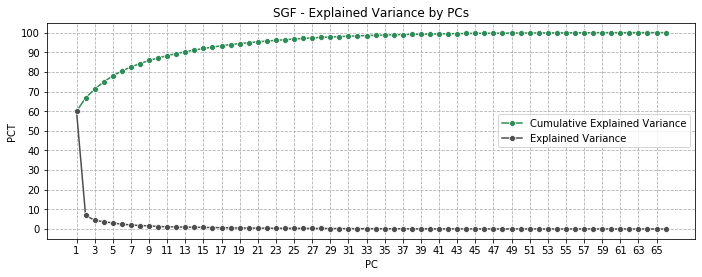

In [78]:
f, axes = plt.subplots(len(subgroups),1)

for i, subgroup in enumerate(subgroups):
    #Below line is to plot cumulative of the same. Activate if it is required
    sns.lineplot(x=sheet_dict[str(subgroup) + '_sdev']["PC"], y=np.cumsum(sheet_dict[str(subgroup) + '_sdev']["PCT"]), marker = "o", ax=axes, color = 'seagreen', label = 'Cumulative Explained Variance')
    sns.lineplot(x="PC", y="PCT", marker = "o", data = sheet_dict[str(subgroup) + '_sdev'], ax=axes, color = '0.3', label = 'Explained Variance')
    axes.set_xticks(np.arange(1, len(sheet_dict[str(subgroup) + '_sdev']),2))
    axes.set_yticks(np.arange(0,101,10))
    axes.grid(True, linestyle = '--')
    axes.set_title('SGF - Explained Variance by PCs')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.50, top=0.75)

plt.savefig('../02_Export/FIGURES/Explained_Var.png', bbox_inches="tight", dpi=300)

In [79]:
#create a dictionary to collect all source files for column and sample names
source_dict = {}
for subgroup in subgroups:
    #source_dict[subgroup] = pd.read_csv('PCA_source_files/' + str(subgroup) +'.csv')
    source_dict[subgroup] = pd.read_csv('../02_Export/CSV/DB_SG_ORIG_IMPUTTED_PCA.csv')

In [80]:
columns_dict = {}

#columns_dict['MA_ORE'] = source_dict['MA_ORE'].iloc[:,10:].columns.tolist()
#columns_dict['MA_HOST'] = source_dict['MA_HOST'].iloc[:,10:].columns.tolist()
#columns_dict['VZN_ALL'] = source_dict['VZN_ALL'].iloc[:,27:].columns.tolist()
columns_dict['VZN_SG'] = source_dict['VZN_SG'].iloc[:,19:-66].columns.tolist()
#columns_dict['ORE_ALL'] = source_dict['ORE_ALL'].iloc[:,9:].columns.tolist()

In [81]:
#Create a column for variable names in rotation(loading) sheet and put the names
for subgroup in subgroups:
    #below 2 lines iare to create a new column with the variable names and muted for now, I used variable names as index instead. I kept them just in case it is needed in the future
    #sheet_dict[str(subgroup)+'_rotation']['Variable'] = np.nan
    #sheet_dict[str(subgroup)+'_rotation']['Variable'] = columns_dict[subgroup]
    #below line is to assign variable names as index
    sheet_dict[str(subgroup)+'_rotation'].index = columns_dict['VZN_SG']

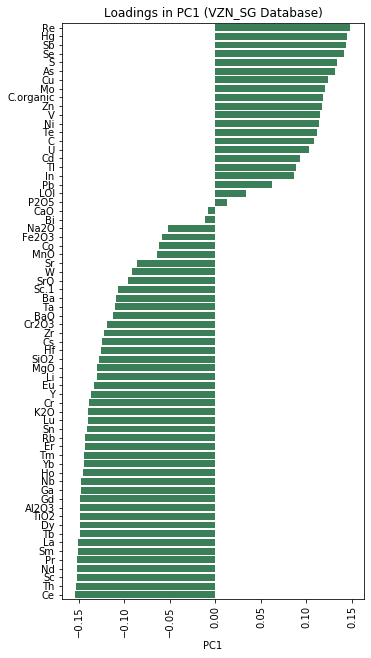

In [82]:
i=0
sns.barplot(x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False), y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'seagreen')
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
plt.xticks(rotation = 90)
plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2, wspace=0.1, hspace=0.4)
#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

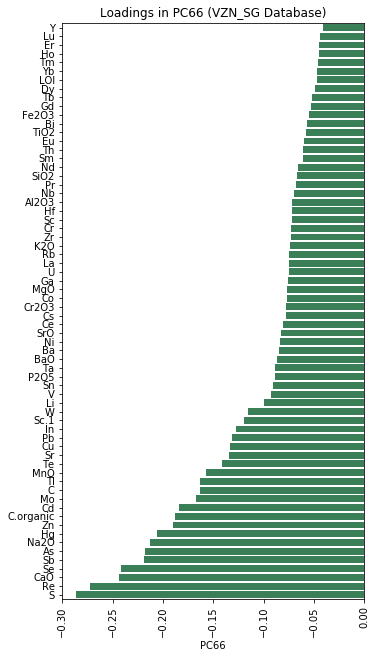

In [83]:
for subgroup in subgroups:
    for i in range(len(sheet_dict[str(subgroup) + '_rotation'].columns.tolist())):
        plt.clf()
        sns.barplot(x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False), y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'seagreen')
        #sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
        plt.xticks(rotation = 90)
        plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')
        plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2, wspace=0.1, hspace=0.4)
        plt.savefig('../02_Export/FIGURES/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

In [84]:
#create a dictionary to collect all source files for column and sample names
square_loading = {}
for subgroup in subgroups:
    square_loading[subgroup] = sheet_dict[str(subgroup) + '_rotation'] * sheet_dict[str(subgroup) + '_rotation']

In [85]:
square_loading[str(subgroup)].T['Cu'].sort_values(ascending=False)

PC13   0.092
PC30   0.075
PC37   0.075
PC36   0.074
PC16   0.070
PC20   0.058
PC31   0.040
PC40   0.037
PC15   0.036
PC27   0.032
PC17   0.031
PC12   0.030
PC19   0.026
PC18   0.024
PC25   0.021
PC21   0.020
PC26   0.020
PC24   0.019
PC41   0.018
PC52   0.018
PC66   0.018
PC3    0.017
PC6    0.016
PC1    0.015
PC28   0.011
PC43   0.010
PC4    0.008
PC10   0.007
PC7    0.007
PC22   0.007
PC38   0.005
PC5    0.004
PC2    0.004
PC49   0.004
PC50   0.004
PC8    0.004
PC33   0.004
PC53   0.004
PC39   0.004
PC11   0.003
PC9    0.003
PC45   0.003
PC42   0.002
PC34   0.002
PC29   0.002
PC32   0.002
PC60   0.002
PC48   0.002
PC58   0.002
PC55   0.001
PC47   0.001
PC14   0.001
PC23   0.001
PC44   0.001
PC56   0.001
PC61   0.001
PC51   0.001
PC35   0.000
PC46   0.000
PC54   0.000
PC64   0.000
PC59   0.000
PC65   0.000
PC63   0.000
PC62   0.000
PC57   0.000
Name: Cu, dtype: float64

In [86]:
subgroups

array(['VZN_SG'], dtype='<U6')

In [87]:
square_loading[str(subgroup)].T

,Al2O3,BaO,CaO,Cr2O3,Fe2O3,K2O,MgO,MnO,Na2O,P2O5,SiO2,SrO,TiO2,Ba,Ce,Cr,Cs,Dy,Er,Eu,Ga,Gd,Hf,Ho,La,Lu,Nb,Nd,Pr,Rb,Sm,Sn,Sr,Ta,Tb,Th,Tm,U,V,W,Y,Yb,Zr,Cd,Co,Cu,Li,Mo,Ni,Pb,Sc,Zn,As,Bi,Hg,In,Re,Sb,Sc.1,Se,Te,Tl,S,C,C.organic,LOI
PC1,0.022,0.013,0.000,0.014,0.003,0.020,0.017,0.004,0.003,0.000,0.016,0.009,0.022,0.012,0.024,0.019,0.016,0.022,0.021,0.018,0.022,0.022,0.016,0.021,0.023,0.020,0.022,0.023,0.023,0.020,0.023,0.020,0.007,0.012,0.022,0.024,0.021,0.011,0.013,0.008,0.019,0.021,0.015,0.009,0.004,0.015,0.017,0.015,0.013,0.004,0.023,0.014,0.017,0.000,0.021,0.007,0.022,0.021,0.012,0.020,0.013,0.008,0.018,0.012,0.014,0.001
PC2,0.004,0.024,0.160,0.000,0.007,0.028,0.015,0.105,0.084,0.051,0.009,0.045,0.010,0.029,0.001,0.002,0.027,0.002,0.007,0.002,0.003,0.000,0.003,0.004,0.002,0.008,0.007,0.000,0.001,0.018,0.000,0.005,0.073,0.003,0.001,0.005,0.008,0.030,0.017,0.000,0.007,0.009,0.003,0.010,0.000,0.004,0.018,0.007,0.030,0.000,0.003,0.002,0.002,0.016,0.003,0.004,0.001,0.004,0.001,0.000,0.000,0.059,0.008,0.003,0.006,0.000
PC3,0.008,0.003,0.002,0.000,0.040,0.003,0.016,0.017,0.106,0.050,0.004,0.027,0.002,0.002,0.003,0.013,0.004,0.005,0.007,0.004,0.010,0.004,0.000,0.005,0.006,0.002,0.005,0.003,0.004,0.010,0.000,0.005,0.009,0.005,0.005,0.004,0.004,0.015,0.028,0.002,0.015,0.002,0.000,0.012,0.000,0.017,0.001,0.034,0.013,0.002,0.003,0.009,0.000,0.074,0.000,0.000,0.000,0.003,0.055,0.006,0.008,0.061,0.002,0.025,0.000,0.211
PC4,0.000,0.001,0.003,0.000,0.159,0.001,0.001,0.009,0.000,0.025,0.005,0.006,0.001,0.000,0.003,0.001,0.000,0.004,0.009,0.001,0.001,0.000,0.014,0.009,0.003,0.013,0.000,0.001,0.002,0.000,0.000,0.002,0.004,0.005,0.001,0.000,0.010,0.036,0.022,0.000,0.009,0.012,0.015,0.030,0.215,0.008,0.019,0.000,0.026,0.078,0.000,0.018,0.027,0.087,0.009,0.005,0.011,0.013,0.011,0.001,0.001,0.001,0.014,0.017,0.013,0.006
PC5,0.007,0.006,0.017,0.028,0.012,0.014,0.003,0.005,0.001,0.050,0.007,0.024,0.000,0.003,0.000,0.018,0.021,0.009,0.014,0.000,0.003,0.011,0.000,0.007,0.001,0.003,0.000,0.000,0.000,0.008,0.003,0.000,0.032,0.003,0.008,0.000,0.008,0.007,0.000,0.028,0.019,0.006,0.001,0.015,0.014,0.004,0.000,0.001,0.004,0.007,0.004,0.039,0.007,0.001,0.000,0.177,0.000,0.000,0.069,0.009,0.014,0.004,0.016,0.102,0.097,0.029
PC6,0.008,0.027,0.000,0.001,0.000,0.007,0.001,0.008,0.000,0.011,0.017,0.001,0.001,0.050,0.000,0.032,0.011,0.002,0.017,0.003,0.014,0.000,0.111,0.008,0.001,0.033,0.001,0.000,0.000,0.008,0.000,0.000,0.005,0.001,0.000,0.001,0.012,0.050,0.014,0.010,0.008,0.018,0.123,0.068,0.009,0.016,0.005,0.002,0.000,0.001,0.005,0.050,0.026,0.007,0.000,0.041,0.000,0.012,0.010,0.001,0.099,0.003,0.016,0.000,0.004,0.009
PC7,0.002,0.106,0.000,0.001,0.018,0.005,0.028,0.007,0.001,0.001,0.011,0.006,0.000,0.107,0.001,0.007,0.000,0.020,0.007,0.060,0.001,0.018,0.020,0.014,0.002,0.004,0.006,0.002,0.002,0.000,0.006,0.002,0.008,0.040,0.017,0.000,0.004,0.003,0.003,0.025,0.030,0.003,0.026,0.013,0.002,0.007,0.001,0.034,0.024,0.073,0.001,0.011,0.001,0.092,0.000,0.016,0.002,0.002,0.032,0.007,0.030,0.006,0.000,0.011,0.012,0.001
PC8,0.006,0.000,0.000,0.024,0.096,0.007,0.047,0.026,0.001,0.008,0.007,0.013,0.003,0.000,0.003,0.007,0.025,0.009,0.009,0.002,0.003,0.004,0.017,0.011,0.004,0.003,0.003,0.002,0.003,0.006,0.001,0.001,0.075,0.001,0.014,0.000,0.010,0.014,0.021,0.012,0.024,0.005,0.014,0.011,0.002,0.004,0.026,0.018,0.023,0.207,0.005,0.018,0.000,0.037,0.004,0.034,0.004,0.005,0.014,0.001,0.002,0.025,0.002,0.010,0.002,0.007
PC9,0.003,0.064,0.040,0.032,0.007,0.007,0.011,0.018,0.008,0.218,0.053,0.023,0.001,0.066,0.000,0.006,0.001,0.003,0.001,0.000,0.002,0.001,0.037,0.002,0.000,0.000,0.004,0.000,0.000,0.001,0.000,0.001,0.003,0.015,0.000,0.000,0.001,0.009,0.003,0.040,0.003,0.000,0.037,0.089,0.000,0.003,0.001,0.002,0.003,0.011,0.001,0.036,0.001,0.027,0.007,0.021,0.000,0.006,0.000,0.000,0.009,0.000,0.000,0.035,0.010,0.013
PC10,0.013,0.055,0.036,0.031,0.022,0.001,0.006,0.001,0.020,0.000,0.002,0.023,0.008,0.029,0.008,0.010,0.022,0.003,0.000,0.024,0.020,0.005,0.007,0.001,0.003,0.002,0.008,0.011,0

In [88]:
square_loading[str(subgroup)].T.loc["PC1":"PC13",'Zn']

PC1    0.014
PC2    0.002
PC3    0.009
PC4    0.018
PC5    0.039
PC6    0.050
PC7    0.011
PC8    0.018
PC9    0.036
PC10   0.039
PC11   0.000
PC12   0.000
PC13   0.002
Name: Zn, dtype: float64

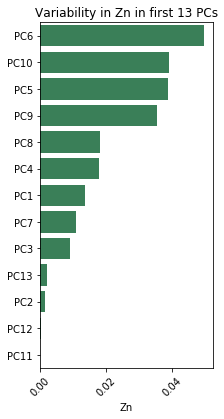

In [89]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T.loc["PC1":"PC13",'Zn'].sort_values(ascending=False), y = square_loading[str(subgroup)].T.loc["PC1":"PC13",'Zn'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Zn in first 13 PCs')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.4, top=1.2, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'Zn_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

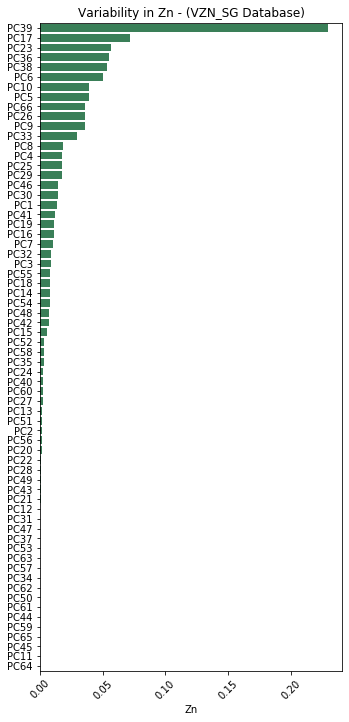

In [90]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['Zn'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['Zn'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Zn - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    #plt.savefig('../02_Export/FIGURES/' + 'Zn_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

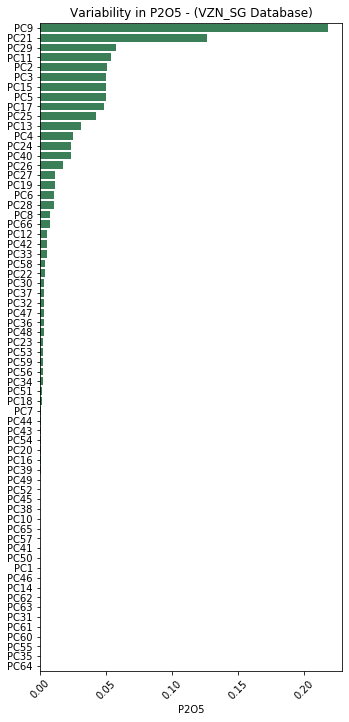

In [91]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['P2O5'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['P2O5'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in P2O5 - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'P2O5_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

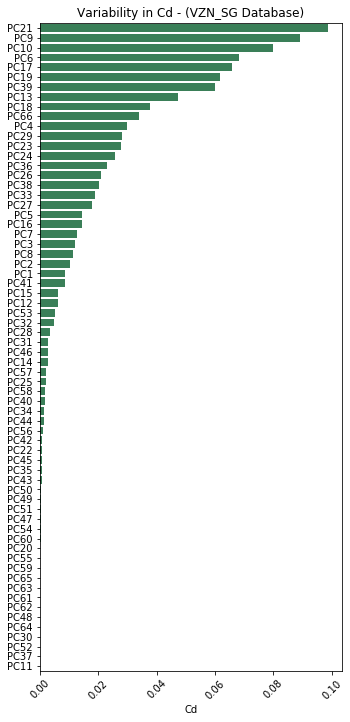

In [92]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['Cd'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['Cd'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Cd - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'Cd_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

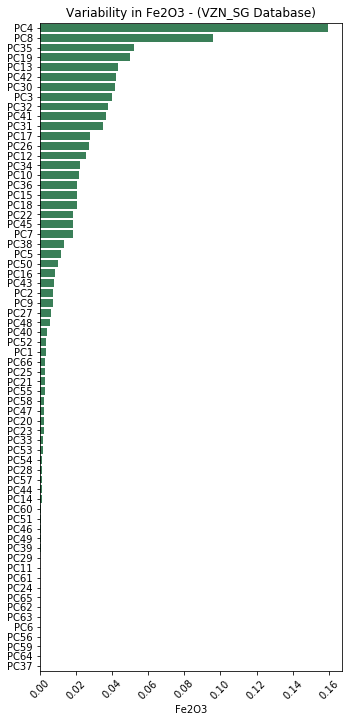

In [93]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['Fe2O3'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['Fe2O3'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Fe2O3 - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'Fe2O3_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

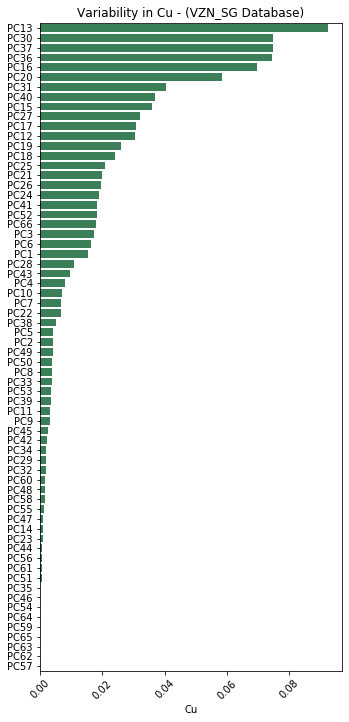

In [94]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['Cu'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['Cu'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Cu - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'Cu_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

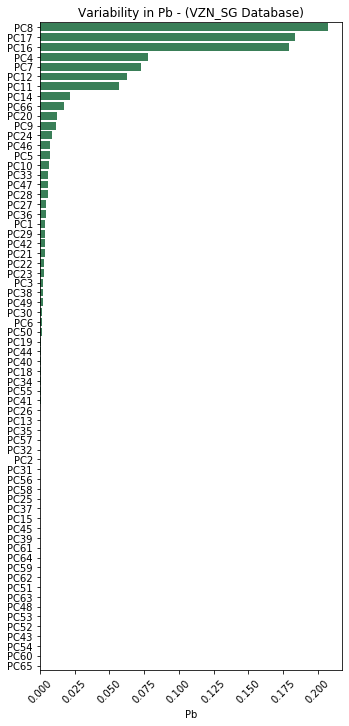

In [95]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['Pb'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['Pb'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in Pb - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'Pb_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

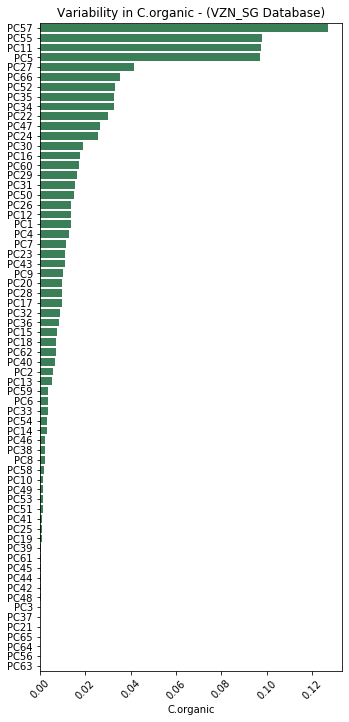

In [96]:
for subgroup in subgroups:
    plt.clf()
    sns.barplot(x = square_loading[str(subgroup)].T['C.organic'].sort_values(ascending=False), y = square_loading[str(subgroup)].T['C.organic'].sort_values(ascending=False).index, color = 'seagreen')
    plt.xticks(rotation = 45)
    plt.title('Variability in C.organic - (' + str(subgroup) + ' Database)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=2.25, wspace=0.1, hspace=0.4)
    plt.savefig('../02_Export/FIGURES/' + 'C.organic_' + str(subgroup) + '_PC' + '.png', format = 'png', bbox_inches = 'tight')

In [97]:
data = pd.read_csv('../02_Export/CSV/DB_SG_ORIG_IMPUTTED_PCA.csv')

In [98]:
data.head()

,Unnamed: 0,Source,Year,Sample,UTM_X,Random_X,UTM_Y,Random_Y,UTM_Z,Z_True,Region,Occurrence,Section,Hole.ID,Depth,Unit,Subunit,Lithofacies,Orebody,Al2O3,BaO,CaO,Cr2O3,Fe2O3,K2O,MgO,MnO,Na2O,P2O5,SiO2,SrO,TiO2,Ba,Ce,Cr,Cs,Dy,Er,Eu,Ga,Gd,Hf,Ho,La,Lu,Nb,Nd,Pr,Rb,Sm,Sn,Sr,Ta,Tb,Th,Tm,U,V,W,Y,Yb,Zr,Cd,Co,Cu,Li,Mo,Ni,Pb,Sc,Zn,As,Bi,Hg,In,Re,Sb,Sc.1,Se,Te,Tl,S,C,C.organic,LOI,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66
0,1,Fernandes,2016,VZRO032000,307100.000,308995.000,8144353.000,8144674.000,578.200,403.600,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,174.600,Serra do Garrote,SG1,Sandstone-Siltstone,nan,139400,900,1700,100,58500,37000,28300,300,5700,800,684600.000,100,7600,795.000,73.200,80,8.120,4.340,2.720,0.940,21.200,4.750,6.000,0.880,36.400,0.420,13.400,31.400,8.060,138.500,6.210,3,81.700,1.000,0.740,12.950,0.400,4.230,83,3.000,25.600,2.890,233,1.098,15,26,40,1.000,32,18.000,12,122,2.300,0.210,0.051,0.049,0.001,0.220,5.300,0.500,0.070,0.070,800,3600,3500,34200,-5.090,0.719,-0.824,0.777,-2.470,0.545,-2.486,0.895,-0.612,-0.121,-0.382,0.379,-0.661,-0.297,1.148,0.306,0.306,0.618,-1.025,-0.629,0.423,-1.265,-0.563,0.122,-0.025,0.085,0.634,0.638,-0.258,-0.531,0.169,-0.009,-0.253,0.443,0.251,0.012,-0.526,-0.341,0.097,0.275,0.068,0.319,-0.149,0.373,0.429,-0.022,-0.064,-0.067,0.093,-0.112,-0.192,-0.040,-0.118,0.085,-0.122,-0.195,-0.008,0.102,-0.032,-0.109,-0.025,-0.002,0.001,-0.034,-0.002,0.000
1,2,Fernandes,2016,VZRO032001,307100.000,303235.000,8144353.000,8145102.000,578.200,379.900,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,198.300,Serra do Garrote,SG1,Sandstone-Siltstone,nan,114200,600,1900,100,56200,28300,26300,300,5200,700,730300.000,100,6000,645.000,70.700,60,6.430,3.790,2.400,0.860,16.900,4.850,6.300,0.780,33.400,0.370,11.200,30.600,7.960,106.500,6.310,2,51.700,11.000,0.710,10.750,0.350,2.290,70,3.000,22.300,2.380,240,1.177,13,18,40,1.000,27,17.000,10,207,3.500,0.160,0.084,0.067,0.001,0.240,3.900,0.600,0.090,0.080,600,2000,1700,28800,-4.681,1.749,-0.275,0.922,-3.800,0.494,-4.341,0.711,1.617,-0.603,-1.481,-1.559,-2.344,-1.003,-1.969,0.521,-1.139,1.984,-1.056,2.551,1.007,-0.239,-0.021,-0.169,0.162,1.520,-0.560,0.388,-0.320,-0.586,-0.146,0.240,-0.314,0.375,0.095,0.196,-0.134,-0.061,0.013,-0.045,-0.294,-0.239,-0.210,0.051,-0.132,-0.195,0.007,0.194,0.238,0.010,0.014,0.141,-0.158,0.167,-0.045,-0.192,0.117,0.069,0.036,0.017,-0.059,0.004,0.011,0.027,-0.018,0.000
2,3,Fernandes,2016,VZRO032002,307100.000,303372.000,8144353.000,8144485.000,578.200,345.100,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,233.100,Serra do Garrote,SG1,Sandstone-Siltstone,nan,118900,1500,47700,100,63700,28200,63100,1500,6300,1100,563800.000,200,6900,1455.000,59.900,60,5.950,3.900,2.440,0.870,18.200,4.330,4.900,0.830,28.800,0.350,11.700,27.400,7.000,109.000,5.530,2,200.000,0.700,0.690,9.440,0.380,2.230,76,3.000,22.700,2.490,194,1.091,13,32,50,1.250,28,16.000,11,111,2.500,0.190,0.037,0.039,0.001,0.150,6.500,0.700,0.030,0.090,600,20100,1600,99900,-2.999,5.519,-5.023,0.151,-0.173,-2.313,-3.725,0.906,-3.451,0.309,-0.489,0.749,0.172,-1.796,1.322,-0.402,0.001,-0.370,-0.396,-0.202,0.929,-0.970,0.127,-1.292,-0.853,-0.369,-0.516,-0.816,-0.523,0.121,0.832,-0.146,0.049,0.117,-0.044,-0.438,-0.292,-0.072,0.527,-0.094,0.142,0.361,0.099,-0.019,0.180,-0.244,-0.224,0.174,0.166,-0.063,-0.071,-0.406,0.107,0.009,-0.055,0.046,-0.025,0.187,0.091,-0.013,-0.085,-0.080,-0.066,-0.031,0.014,0.000
3,4,Fernandes,2016,VZRO032003,307100.000,306161.000,8144353.000,8143607.000,578.200,309.800,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,268.400,Serra do Garrote,SG1,Dolomitic Argillaceous Sandstone,nan,88200,400,154000,50,49400,18800,40900,1600,5800,700,471800.000,200,5200,330.

In [99]:
data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,203.000,NaN,NaN,NaN,102.000,58.745,1.000,51.500,102.000,152.500,203.000
Source,203,1,Fernandes,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,203.000,NaN,NaN,NaN,2016.000,0.000,2016.000,2016.000,2016.000,2016.000,2016.000
Sample,203,203,VZRO032068,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UTM_X,203.000,NaN,NaN,NaN,306871.499,6658.191,291975.080,302350.000,307983.600,312956.000,313393.340
Random_X,203.000,NaN,NaN,NaN,307613.070,12747.091,273972.080,298457.095,308601.080,316797.500,331956.000
UTM_Y,203.000,NaN,NaN,NaN,8046095.191,46898.841,7986586.830,8019037.310,8025677.000,8095565.130,8144353.000
Random_Y,203.000,NaN,NaN,NaN,8046112.541,46908.600,7985682.830,8018269.810,8025462.000,8095063.630,8145102.000
UTM_Z,203.000,NaN,NaN,NaN,691.941,63.563,573.000,635.904,700.755,712.200,824.350
Z_True,203.000,NaN,NaN,NaN,427.228,154.686,-336.750,403.425,465.700,512.162,599.940


In [100]:
len(data['UTM_Y'].unique())

15

In [101]:
data['Occurrence'].unique()

array(['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', 'North Extension', 'Mata Preta', "Olho D'Agua",
       'Varginha'], dtype=object)

In [102]:
data['Lithofacies'].unique().tolist()

['Sandstone-Siltstone',
 'Dolomitic  Argillaceous Sandstone',
 'Carbonaceous Phyllite',
 'Phyllite',
 'Siliceous Phyllite',
 'Siliceous Carbonaceous Phyllite',
 'Arenite',
 'Argillaceous Arenite',
 'Carbonaceous Arenite']

In [103]:
markers = {
'Sandstone-Siltstone':'*',
'Dolomitic  Argillaceous Sandstone':'o',
'Carbonaceous Phyllite':'v',
'Phyllite':'^',
'Siliceous Phyllite':'<',
'Siliceous Carbonaceous Phyllite':'>',
'Arenite':'s',
'Argillaceous Arenite':'P',
'Carbonaceous Arenite':'D',
}

In [104]:
from matplotlib import colors
divnorm = colors.DivergingNorm(vmin=-0.15, vcenter=0., vmax=0.15)

In [105]:
data['Log_Zn'] = np.log10(data['Zn'])

In [106]:
np.arange(1,7,1)

array([1, 2, 3, 4, 5, 6])

In [107]:
sheet_dict[str(subgroup) + '_rotation'].rename(index={'Sc':'Sc-4AC','Sc.1':'Sc','C.organic':'Org C'}, inplace=True)

In [108]:
sheet_dict[str(subgroup) + '_rotation']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66
Al2O3,-0.149,-0.060,0.092,-0.016,0.085,-0.089,0.046,-0.076,0.055,-0.114,0.005,-0.003,0.060,-0.029,0.093,-0.036,0.054,-0.042,0.020,-0.011,0.049,-0.039,-0.017,0.082,0.124,-0.015,-0.044,0.028,0.011,0.085,-0.020,-0.072,-0.155,0.187,-0.084,-0.014,-0.099,0.054,0.035,0.022,0.030,0.014,0.171,-0.031,-0.246,-0.078,0.028,0.058,0.002,0.013,0.116,0.216,0.067,-0.173,-0.018,-0.007,-0.339,-0.383,0.295,0.427,-0.200,-0.029,-0.061,-0.041,-0.075,-0.071
BaO,-0.112,-0.153,-0.058,0.027,0.075,-0.165,-0.325,0.001,-0.254,0.234,0.101,0.022,0.040,-0.039,0.122,0.040,-0.079,0.040,-0.183,0.054,0.078,-0.178,0.021,-0.077,0.031,0.130,0.040,-0.104,-0.018,0.041,-0.004,-0.149,0.039,-0.179,0.025,0.035,-0.120,-0.024,0.092,0.150,0.030,-0.044,-0.010,0.074,0.146,0.172,0.141,0.167,-0.183,-0.116,-0.368,0.158,0.143,-0.031,-0.103,0.189,-0.043,-0.115,0.085,-0.140,-0.100,-0.044,-0.038,-0.046,0.004,-0.086
CaO,-0.008,0.401,-0.042,0.056,0.131,-0.006,-0.010,-0.004,-0.201,0.189,0.202,-0.016,-0.189,-0.059,-0.032,0.021,-0.143,-0.160,0.157,-0.116,-0.040,0.082,-0.077,-0.136,-0.232,0.176,-0.130,0.288,-0.009,0.004,-0.151,-0.076,-0.116,0.180,-0.004,0.034,0.085,0.327,-0.059,0.180,-0.163,-0.053,-0.146,-0.031,-0.031,-0.040,0.054,-0.052,0.041,-0.000,-0.011,0.012,0.013,-0.068,0.009,0.023,-0.047,0.016,-0.031,0.001,-0.038,-0.030,-0.006,-0.001,0.025,-0.244
Cr2O3,-0.119,-0.013,-0.007,-0.000,0.166,-0.032,0.027,-0.156,0.178,-0.176,-0.045,0.173,0.072,0.079,-0.184,0.317,-0.297,0.233,0.070,-0.285,0.490,0.032,-0.237,-0.289,-0.067,-0.154,0.077,-0.024,-0.042,0.024,0.015,-0.051,0.078,-0.074,0.052,-0.022,-0.008,0.063,0.021,-0.068,-0.040,0.003,0.020,0.043,-0.036,-0.033,-0.019,0.017,-0.004,-0.010,-0.039,0.015,0.020,-0.018,0.006,0.016,0.016,0.025,0.007,-0.010,0.023,0.035,-0.011,0.001,-0.002,-0.078
Fe2O3,-0.059,0.085,-0.200,-0.399,-0.107,0.004,0.136,-0.310,0.085,-0.148,0.016,-0.160,0.207,-0.032,-0.144,0.092,0.166,-0.143,-0.224,0.048,0.052,-0.136,0.046,-0.014,0.053,0.165,0.079,0.036,-0.018,-0.204,-0.187,-0.195,0.043,0.149,0.228,0.144,-0.001,0.117,-0.020,0.064,0.191,0.205,-0.089,-0.034,0.136,-0.023,0.048,0.077,-0.020,-0.100,0.025,-0.060,0.043,-0.037,0.051,-0.003,-0.034,0.049,-0.003,-0.030,0.015,0.010,-0.007,0.002,0.013,-0.054
K2O,-0.140,-0.167,0.056,0.024,0.120,-0.083,-0.072,-0.084,-0.082,0.037,0.046,0.029,-0.001,-0.016,0.004,0.008,0.083,-0.010,-0.004,-0.046,-0.023,0.049,0.019,0.026,0.106,0.004,0.016,0.001,0.087,0.002,-0.167,-0.008,0.012,0.008,-0.085,0.139,-0.042,0.054,0.021,0.032,0.052,-0.072,-0.053,-0.046,-0.118,0.203,0.030,-0.192,-0.180,0.195,0.140,0.177,0.052,-0.203,0.151,-0.291,0.063,0.080,0.175,-0.140,0.477,0.352,0.055,0.050,0.097,-0.074
MgO,-0.130,0.122,-0.128,-0.026,-0.052,0.027,-0.166,-0.216,-0.103,0.076,-0.117,0.064,0.024,-0.169,0.006,0.029,0.061,0.004,0.162,0.085,-0.087,-0.076,-0.043,-0.129,-0.076,-0.176,-0.069,-0.125,-0.162,-0.072,0.109,0.250,-0.113,0.097,0.023,-0.176,-0.355,0.059,0.054,-0.115,0.324,-0.137,-0.170,-0.118,0.149,-0.102,-0.277,-0.164,-0.106,0.089,0.083,0.154,0.027,0.044,-0.005,0.095,0.004,0.019,-0.053,0.018,-0.058,0.012,-0.016,-0.007,0.024,-0.076
MnO,-0.064,0.325,-0.130,-0.097,-0.074,-0.089,0.082,-0.161,-0.135,0.028,-0.089,0.080,-0.099,-0.099,0.085,0.431,-0.043,0.052,-0.099,-0.054,-0.123,0.267,0.338,0.063,0.105,0.056,0.268,-0.123,0.149,0.199,0.066,0.018,0.018,-0.020,-0.134,0.029,-0.099,-0.193,-0.101,-0.018,-0.090,-0.039,0.178,-0.087,-0.031,0.019,0.040,0.071,0.028,0.081,0.047,-0.012,-0.023,0.070,-0.058,-0.007,0.060,-0.019,0.001,0.011,0.007,-0.031,0.009,-0.015,0.005,-0.157
Na2O,-0.052,0.290,0.326,-0.009,-0.025,0.022,0.033,-0.032,0.091,-0.142,-0.019,-0.184,-0.109,-0.101,0.206,-0.156,-0.091,-0.011,-0.336,-0.192,-0.084,-0.051,-0.040,0.016,-0.146,-0.111,-0.029,-0.264,-0.052,-

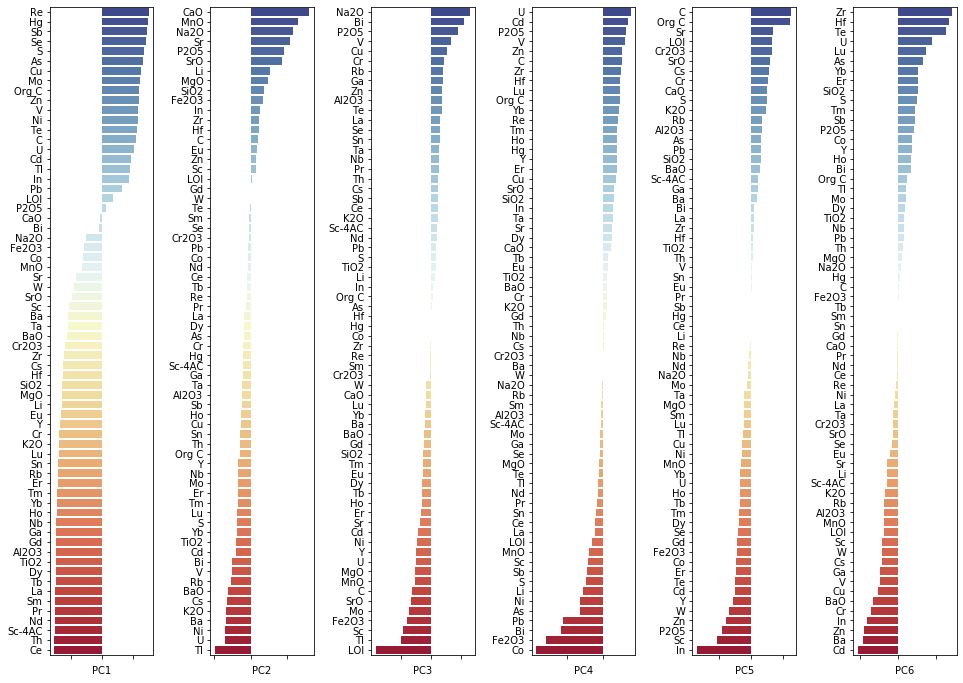

In [109]:
f, axes = plt.subplots(1,6)
ax = axes.flatten()
###PC Loadings
PC = 2

for j,PC in enumerate(np.arange(1,7,1)):
    
    #####################################
    i = PC -1
    sns.barplot(x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False), y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, palette= 'RdYlBu_r', ax = ax[j])
    #sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
    ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.1, top=2.25, wspace=0.55, hspace=0.1)
plt.savefig('../02_Export/FIGURES/PC_Sum.png', bbox_inches="tight", dpi=300)

In [118]:
from matplotlib.legend_handler import HandlerPathCollection

In [152]:
labels

[' ',
 'Subunit',
 'SG1',
 'SG2',
 'SG3',
 'Zn',
 '0',
 '2000',
 '4000',
 '6000',
 'Lithofacies',
 'Sandstone-Siltstone',
 'Dolomitic  Argillaceous Sandstone',
 'Carbonaceous Phyllite',
 'Phyllite',
 'Siliceous Phyllite',
 'Siliceous Carbonaceous Phyllite',
 'Arenite',
 'Argillaceous Arenite',
 'Carbonaceous Arenite',
 'Subunit',
 'SG1',
 'SG2',
 'SG3',
 'Zn',
 '0',
 '2000',
 '4000',
 '6000',
 'Lithofacies',
 'Sandstone-Siltstone',
 'Dolomitic  Argillaceous Sandstone',
 'Carbonaceous Phyllite',
 'Phyllite',
 'Siliceous Phyllite',
 'Siliceous Carbonaceous Phyllite',
 'Arenite',
 'Argillaceous Arenite',
 'Carbonaceous Arenite']

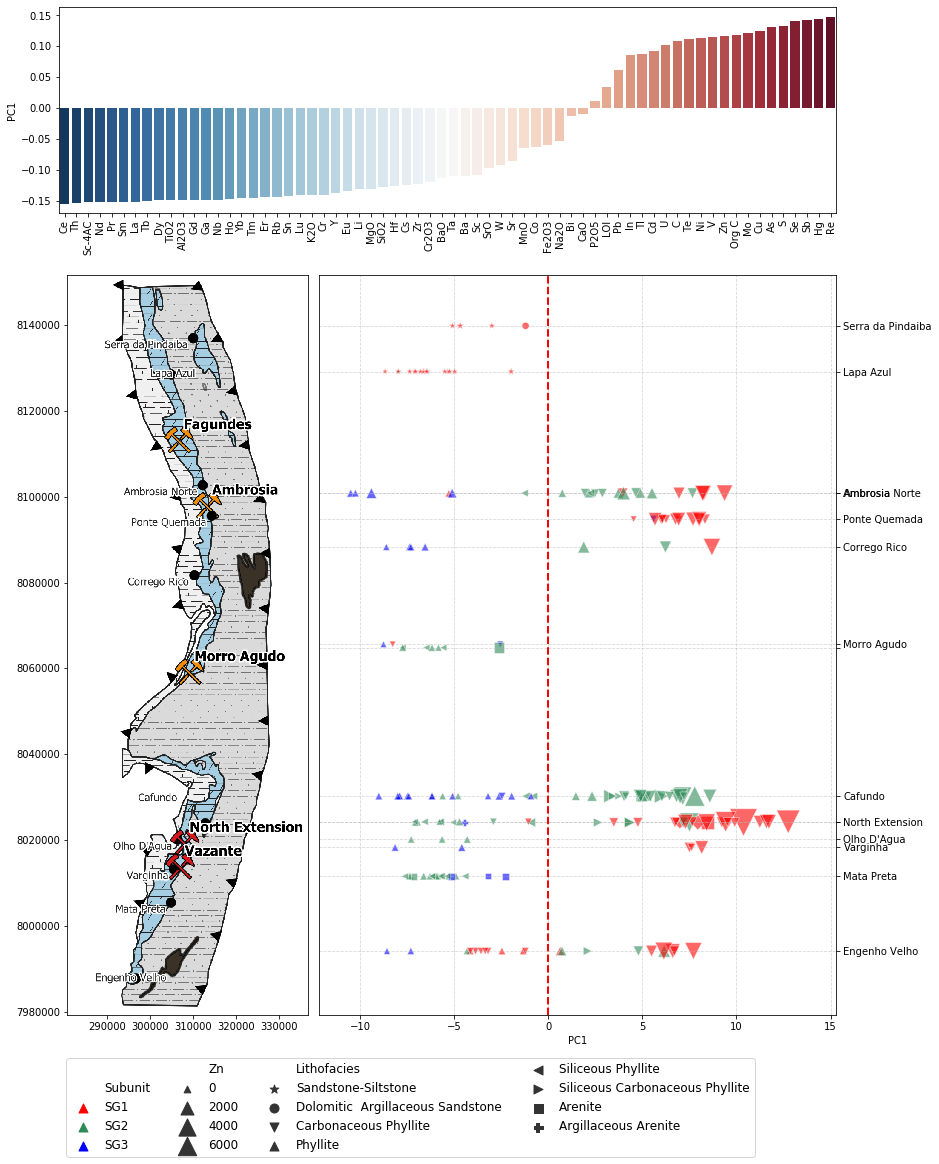

In [156]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 1

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

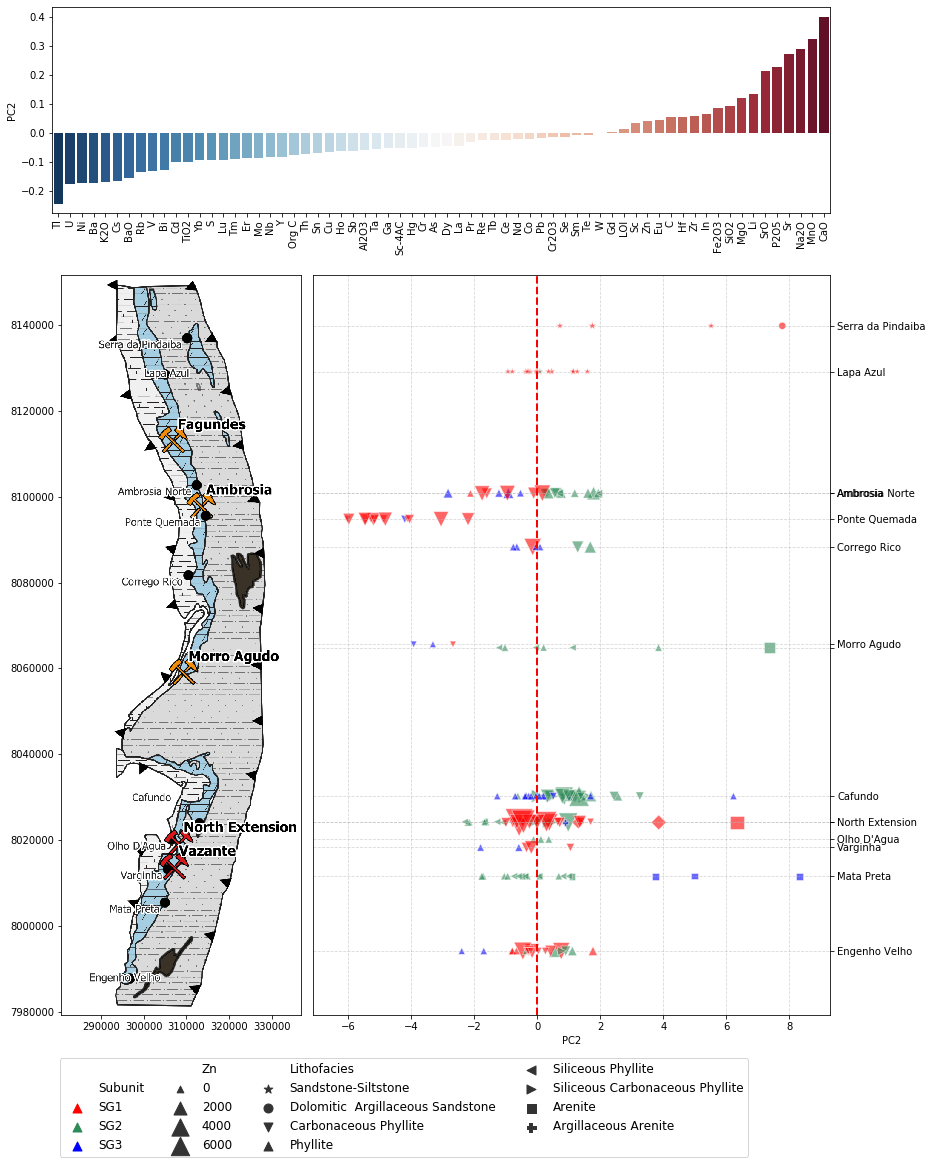

In [161]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 2

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

In [162]:
data.sort_values(by = 'PC6')

,Unnamed: 0,Source,Year,Sample,UTM_X,Random_X,UTM_Y,Random_Y,UTM_Z,Z_True,Region,Occurrence,Section,Hole.ID,Depth,Unit,Subunit,Lithofacies,Orebody,Al2O3,BaO,CaO,Cr2O3,Fe2O3,K2O,MgO,MnO,Na2O,P2O5,SiO2,SrO,TiO2,Ba,Ce,Cr,Cs,Dy,Er,Eu,Ga,Gd,Hf,Ho,La,Lu,Nb,Nd,Pr,Rb,Sm,Sn,Sr,Ta,Tb,Th,Tm,U,V,W,Y,Yb,Zr,Cd,Co,Cu,Li,Mo,Ni,Pb,Sc,Zn,As,Bi,Hg,In,Re,Sb,Sc.1,Se,Te,Tl,S,C,C.organic,LOI,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,Log_Zn
129,130,Fernandes,2016,VZRO032061,305438.190,298372.190,8063992.970,8064980.970,575.550,-336.750,North,Morro Agudo,Morro Agudo,VZMAF21,912.300,Serra do Garrote,SG3,Carbonaceous Phyllite,nan,169000,5700,1300,100,49400,88200,18600,100,900,500,608400.000,100,6300,5750.000,95.000,100,14.350,4.010,2.130,1.010,24.100,4.680,2.400,0.810,51.600,0.300,16.400,40.200,10.800,187.000,6.150,3,31.900,1.200,0.700,12.650,0.350,2.190,111,2.000,21.800,2.130,88,0.946,16,44,60,0.949,57,151.000,15,32,9.900,0.190,0.063,0.012,0.001,0.290,3.500,1.600,0.020,0.190,24500,15200,15000,56000,-2.552,-3.925,-1.069,-2.617,3.966,-5.004,-6.127,2.432,-3.876,2.421,0.998,-2.205,0.697,0.902,-0.039,0.213,-0.503,1.256,-1.397,0.308,0.091,-1.438,-0.557,0.266,0.170,-0.696,1.034,0.509,-0.019,0.020,0.088,-0.123,0.063,-0.503,0.110,0.207,0.439,-0.075,0.010,0.037,-0.404,0.051,-0.158,-0.394,-0.086,0.066,0.013,0.060,-0.022,-0.146,0.065,0.079,0.019,-0.149,0.009,-0.089,-0.045,-0.106,0.012,0.006,0.125,0.024,0.013,0.009,-0.007,0.000,1.505
37,38,Fernandes,2016,VMRO046614,312371.620,304703.620,8102127.590,8102634.590,635.904,546.754,North,Ambrosia Norte,Ambrosia,VZAMF200,89.150,Serra do Garrote,SG3,Phyllite,nan,207700,800,200,100,66200,52300,18800,200,1700,400,595700.000,100,7200,733.000,92.100,120,14.150,4.970,2.860,1.400,29.600,5.420,3.800,0.980,47.700,0.380,12.300,36.700,10.350,202.000,7.310,3,51.100,1.000,0.830,13.450,0.410,1.780,102,2.000,28.500,2.770,129,126.000,17,35,60,2.161,49,5.000,17,350,2.100,0.220,0.028,0.030,0.004,0.270,3.200,2.120,0.010,0.210,1600,1900,1500,41600,-5.104,-2.831,-1.533,0.375,-2.405,-4.902,1.402,-0.088,2.574,2.380,0.160,0.264,-0.654,0.176,-0.077,-1.955,0.167,-0.745,-1.218,0.694,0.957,-0.016,0.948,-0.341,0.915,-1.445,0.623,0.272,0.800,0.364,-0.068,0.108,0.124,-0.120,0.092,-0.696,-0.467,0.552,-0.183,0.128,0.383,0.004,0.346,0.457,-0.128,-0.068,-0.107,0.150,0.073,-0.083,-0.152,-0.044,-0.203,-0.058,0.057,0.007,0.066,0.020,-0.040,-0.055,0.038,0.005,0.004,-0.003,0.014,0.000,2.544
38,39,Fernandes,2016,VMRO046615,312371.620,310799.620,8102127.590,8101550.590,635.904,540.754,North,Ambrosia Norte,Ambrosia,VZAMF200,95.150,Serra do Garrote,SG3,Phyllite,nan,195000,700,900,100,69800,50700,19600,800,1000,600,598300.000,100,6700,668.000,88.800,110,12.800,4.420,2.530,1.240,27.900,5.080,3.700,0.900,45.600,0.370,12.100,35.100,9.910,210.000,6.470,3,45.400,0.900,0.750,12.950,0.400,1.760,91,2.000,24.900,2.410,130,0.756,15,29,50,0.896,43,6.000,17,474,0.600,0.280,0.010,0.025,0.001,0.110,2.900,0.200,0.010,0.080,500,3900,700,43800,-9.394,-0.915,-1.447,-0.780,-1.782,-3.187,1.779,-0.678,-0.957,0.270,0.205,0.753,0.700,-0.902,0.403,0.503,0.743,0.235,0.484,0.614,-0.003,-0.140,0.039,-0.126,-0.193,1.154,-0.118,-0.029,0.413,0.923,-0.703,-0.199,0.287,0.027,-0.137,0.672,0.163,-0.820,0.654,-0.421,-0.335,-0.038,0.356,0.276,-0.365,0.057,-0.179,-0.021,-0.112,-0.159,0.089,-0.277,-0.126,0.117,0.126,-0.070,-0.212,0.094,-0.095,-0.043,-0.022,-0.070,0.006,0.012,0.009,0.000,2.676
105,106,Fernandes,2016,VMRO046600,291975.080,296198.080,7986586.830,7985882.830,824.350,586.350,South,Engenho Velho,Engenho Velho,VZEVF001,238.000,Serra do Garrote,SG3,Phyllite,nan,211300,1700,2400,100,55000,67400,22200,300,2000,500,582100.000,100,7600,1765.000,97.700,130,20.900,4.990,2.920,1.470,30.300,5.660,4.100,0.980,50.900,0.430,14.000,

In [163]:
data['Pb / Zn'] = data['Pb'] / data['Zn']
data['Ba / Zn'] = data['Ba'] / data['Zn']
data['BaO / Zn'] = data['BaO'] / data['Zn']
data['Fe2O3 / Zn'] = data['Fe2O3'] / data['Zn']
data['Fe2O3 / Pb'] = data['Fe2O3'] / data['Pb']
data['Zn / Pb'] = data['Zn'] / data['Pb']
data['Zn / Ba'] = data['Zn'] / data['Ba']
data['Zn / BaO'] = data['Zn'] / data['BaO']
data['Zn / Mn'] = data['Zn'] / data['MnO']
data['Zn / Cd'] = data['Zn'] / data['Cd']

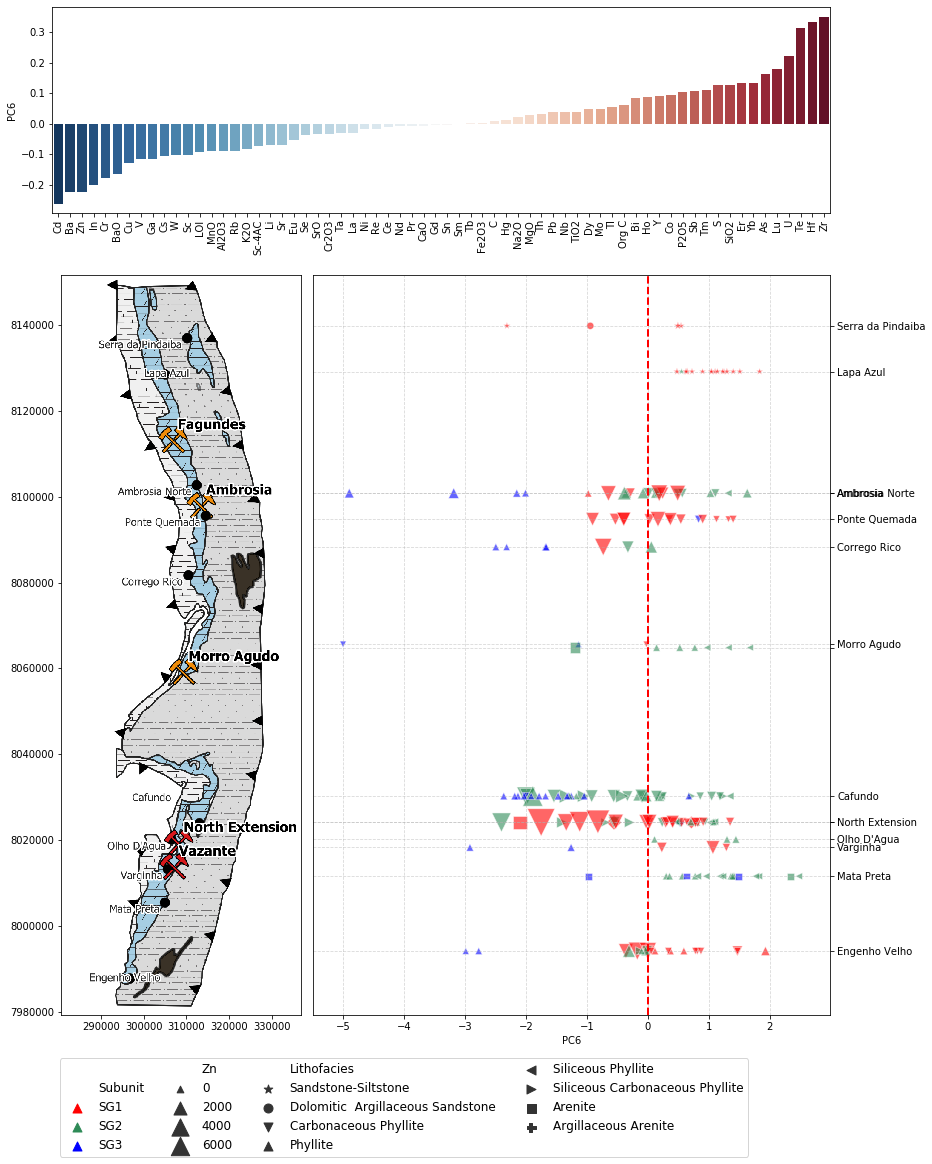

In [164]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 6

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

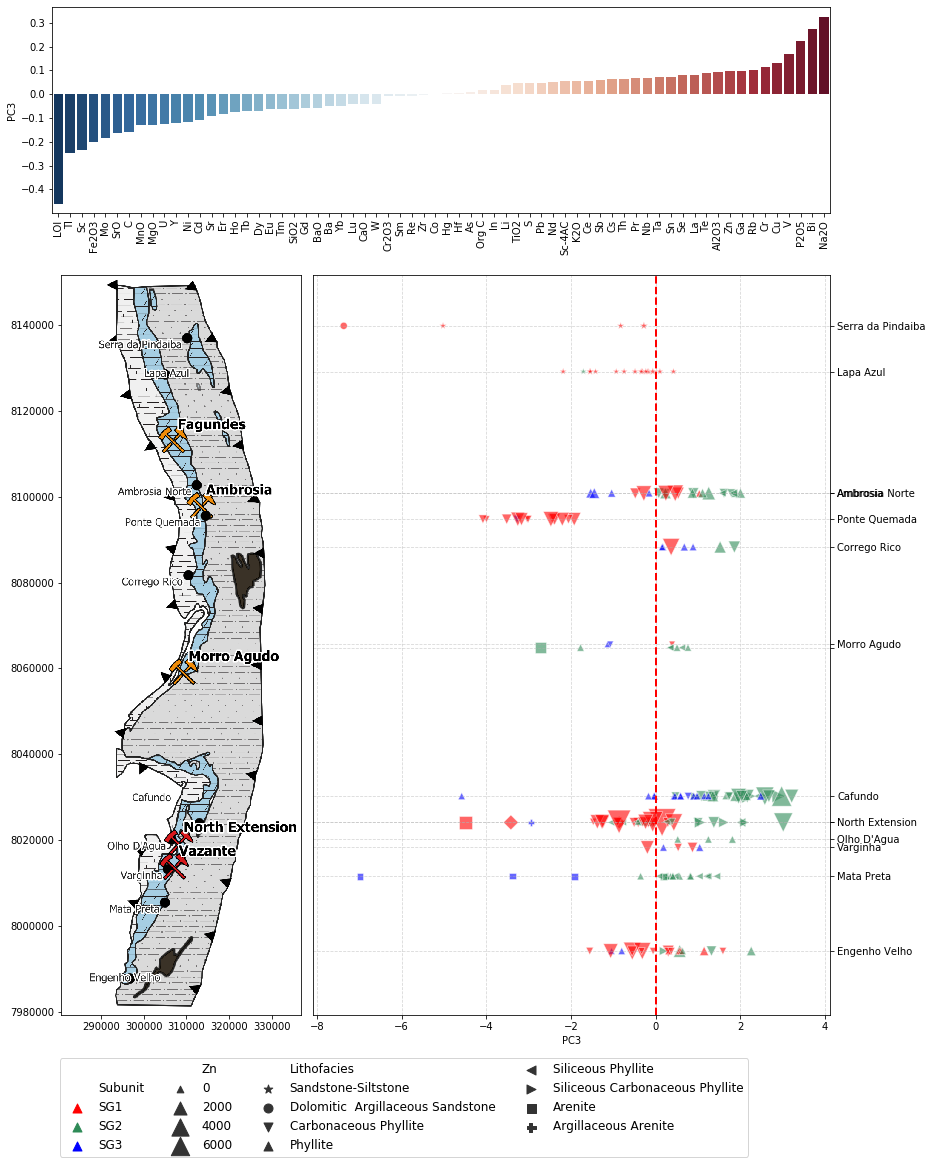

In [165]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 3

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

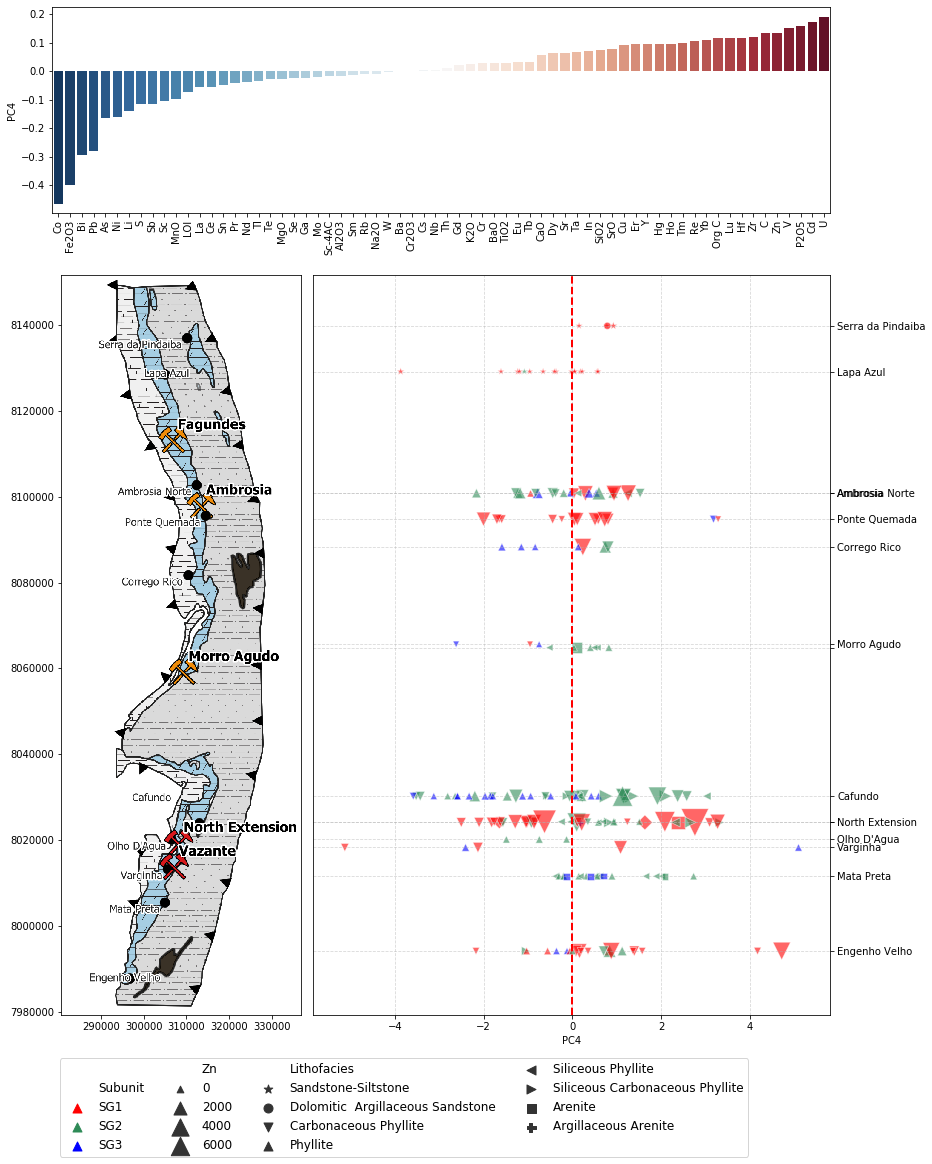

In [166]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 4

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

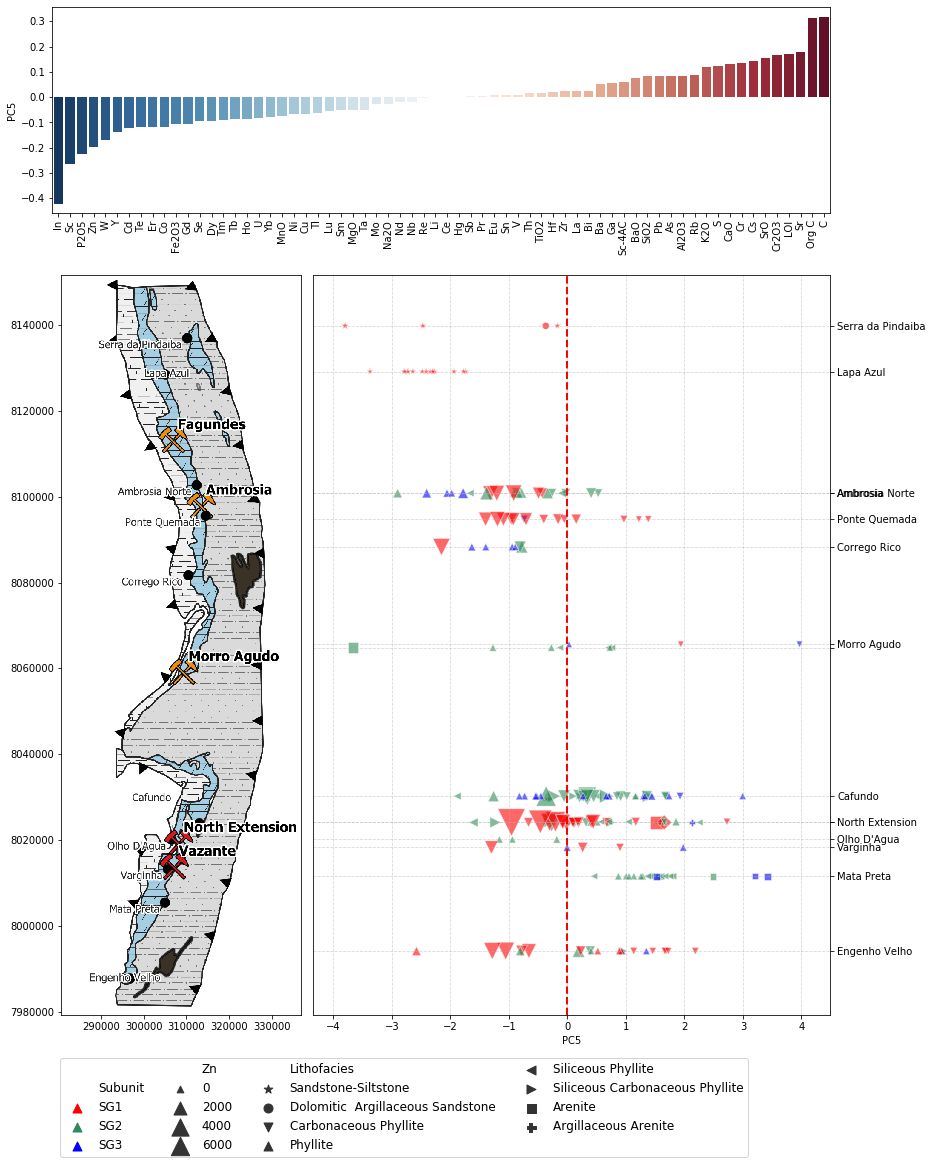

In [167]:
plt.rcParams['scatter.marker'] = '^'

fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[0, :])
f2_ax3 = fig.add_subplot(spec2[1:, 0])
f2_ax4 = fig.add_subplot(spec2[1:, 1:])

###PC Loadings
PC = 5

#####################################
i = PC -1
sns.barplot(y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True), x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=True).index, palette= 'RdBu_r', ax = f2_ax2)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax2.set_xticklabels(f2_ax2.get_xticklabels(), rotation=90)


#plt.title('Loadings in PC' + str(i+1) + ' (' + str(subgroup) + ' Database)')

#plt.savefig('IMAGES_2/' + str(subgroup) + '_PC_' + str (i+1) + '.png', format = 'png', bbox_inches = 'tight')

###MAP

src = rasterio.open("../02_Export/FIGURES/geotif.tif")
show(src.read(), transform=src.transform, ax = f2_ax3)

#f2_ax3.axis('off')

g1 = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(20, 150), 
    alpha = 0, 

    
)

g = sns.scatterplot(
    x='PC'+ str(i+1), 
    y = 'UTM_Y', 
    #data = data.loc[(data['Subunit']=="G3 SERRA DO GARROTE")], 
    data = data,
    hue = 'Subunit',
    hue_order = ['SG1','SG2','SG3'],
    palette= ['red','seagreen','blue'],
    style = 'Lithofacies', 
    markers=markers, 
    ax = f2_ax4, 
    size = 'Zn', 
    sizes=(40, 750), 
    alpha = 0.6, 

    
)


plt.yticks(data['UTM_Y'].unique())
g.set(yticklabels=['Serra da Pindaiba', 'Ponte Quemada', 'Lapa Azul', 'Ambrosia',
       'Ambrosia Norte', 'Cafundo', 'Corrego Rico', 'Engenho Velho',
       'Morro Agudo', '','North Extension','', 'Mata Preta', "Olho D'Agua",
       'Varginha'])
f2_ax4.yaxis.tick_right()
g.set_ylabel('')

g.legend(loc='upper left', bbox_to_anchor=(-0.5,-0.05), ncol=4).set_visible(False)
f2_ax4.grid(True, linestyle = '--', alpha = 0.5)
f2_ax4.axvline(x=0, color = 'red', linewidth = 2, ls = '--')

f2_ax4.plot(np.NaN, np.NaN, '-', color='none', label=' ')
handles, labels = f2_ax4.get_legend_handles_labels()
#labels.insert(5,labels[0])
#handles[2].set_sizes([30])
#handles.insert(5,handles[0])
#labels.insert(10,labels[0])
#handles.insert(10,handles[0])
#labels = labels[1:]
#handles = handles[1:]
handles = handles[:19]
labels = labels[:19]

    
lgd = f2_ax4.legend(handles = handles, labels = labels, ncol=4, prop={"size":12}, 
                bbox_to_anchor=(-0.5,-0.05), loc='upper left', markerscale=1.5, scatterpoints=1, labelspacing = 0.5).set_visible(True)




plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=3.5, wspace=0.01, hspace=0.3)
plt.savefig('../02_Export/FIGURES/SG_MAP_PC' + str(i+1) + '.png', bbox_inches="tight", dpi=300)

In [168]:
data_molar = pd.read_excel('../02_Export/CSV/get_molars.xlsx', index_col='Sample')

In [169]:
data_molar = data_molar.loc[(data_molar['Source'] == 'Fernandes') & (data_molar['Unit'] == 'Serra do Garrote')]

In [170]:
len(data)

203

In [171]:
len(data_molar)

203

In [172]:
data.set_index('Sample', inplace = True)

In [173]:
data = pd.concat([data, data_molar[['Na (Molar)', 'Al (Molar)', 'K (Molar)']]], axis = 1)

In [174]:
data.head()

,Unnamed: 0,Source,Year,UTM_X,Random_X,UTM_Y,Random_Y,UTM_Z,Z_True,Region,Occurrence,Section,Hole.ID,Depth,Unit,Subunit,Lithofacies,Orebody,Al2O3,BaO,CaO,Cr2O3,Fe2O3,K2O,MgO,MnO,Na2O,P2O5,SiO2,SrO,TiO2,Ba,Ce,Cr,Cs,Dy,Er,Eu,Ga,Gd,Hf,Ho,La,Lu,Nb,Nd,Pr,Rb,Sm,Sn,Sr,Ta,Tb,Th,Tm,U,V,W,Y,Yb,Zr,Cd,Co,Cu,Li,Mo,Ni,Pb,Sc,Zn,As,Bi,Hg,In,Re,Sb,Sc.1,Se,Te,Tl,S,C,C.organic,LOI,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,Log_Zn,Pb / Zn,Ba / Zn,BaO / Zn,Fe2O3 / Zn,Fe2O3 / Pb,Zn / Pb,Zn / Ba,Zn / BaO,Zn / Mn,Zn / Cd,Na (Molar),Al (Molar),K (Molar)
Sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VZRO032000,1,Fernandes,2016,307100.000,308995.000,8144353.000,8144674.000,578.200,403.600,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,174.600,Serra do Garrote,SG1,Sandstone-Siltstone,nan,139400,900,1700,100,58500,37000,28300,300,5700,800,684600.000,100,7600,795.000,73.200,80,8.120,4.340,2.720,0.940,21.200,4.750,6.000,0.880,36.400,0.420,13.400,31.400,8.060,138.500,6.210,3,81.700,1.000,0.740,12.950,0.400,4.230,83,3.000,25.600,2.890,233,1.098,15,26,40,1.000,32,18.000,12,122,2.300,0.210,0.051,0.049,0.001,0.220,5.300,0.500,0.070,0.070,800,3600,3500,34200,-5.090,0.719,-0.824,0.777,-2.470,0.545,-2.486,0.895,-0.612,-0.121,-0.382,0.379,-0.661,-0.297,1.148,0.306,0.306,0.618,-1.025,-0.629,0.423,-1.265,-0.563,0.122,-0.025,0.085,0.634,0.638,-0.258,-0.531,0.169,-0.009,-0.253,0.443,0.251,0.012,-0.526,-0.341,0.097,0.275,0.068,0.319,-0.149,0.373,0.429,-0.022,-0.064,-0.067,0.093,-0.112,-0.192,-0.040,-0.118,0.085,-0.122,-0.195,-0.008,0.102,-0.032,-0.109,-0.025,-0.002,0.001,-0.034,-0.002,0.000,2.086,0.148,6.516,7.377,479.508,3250.000,6.778,0.153,0.136,0.407,111.122,0.018,0.273,0.079
VZRO032001,2,Fernandes,2016,307100.000,303235.000,8144353.000,8145102.000,578.200,379.900,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,198.300,Serra do Garrote,SG1,Sandstone-Siltstone,nan,114200,600,1900,100,56200,28300,26300,300,5200,700,730300.000,100,6000,645.000,70.700,60,6.430,3.790,2.400,0.860,16.900,4.850,6.300,0.780,33.400,0.370,11.200,30.600,7.960,106.500,6.310,2,51.700,11.000,0.710,10.750,0.350,2.290,70,3.000,22.300,2.380,240,1.177,13,18,40,1.000,27,17.000,10,207,3.500,0.160,0.084,0.067,0.001,0.240,3.900,0.600,0.090,0.080,600,2000,1700,28800,-4.681,1.749,-0.275,0.922,-3.800,0.494,-4.341,0.711,1.617,-0.603,-1.481,-1.559,-2.344,-1.003,-1.969,0.521,-1.139,1.984,-1.056,2.551,1.007,-0.239,-0.021,-0.169,0.162,1.520,-0.560,0.388,-0.320,-0.586,-0.146,0.240,-0.314,0.375,0.095,0.196,-0.134,-0.061,0.013,-0.045,-0.294,-0.239,-0.210,0.051,-0.132,-0.195,0.007,0.194,0.238,0.010,0.014,0.141,-0.158,0.167,-0.045,-0.192,0.117,0.069,0.036,0.017,-0.059,0.004,0.011,0.027,-0.018,0.000,2.316,0.082,3.116,2.899,271.498,3305.882,12.176,0.321,0.345,0.690,175.823,0.017,0.224,0.060
VZRO032002,3,Fernandes,2016,307100.000,303372.000,8144353.000,8144485.000,578.200,345.100,North,Serra da Pindaiba,Retiro-Pindaiba-Lapa Azul,B5GF10,233.100,Serra do Garrote,SG1,Sandstone-Siltstone,nan,118900,1500,47700,100,63700,28200,63100,1500,6300,1100,563800.000,200,6900,1455.000,59.900,60,5.950,3.900,2.440,0.870,18.200,4.330,4.900,0.830,28.800,0.350,11.700,27.400,7.000,109.000,5.530,2,200.000,0.700,0.690,9.440,0.380,2.230,76,3.000,22.700,2.490,194,1.091,13,32,50,1.250,28,16.000,11,111,2.500,0.190,0.037,0.039,0.001,0.150,6.500,0.700,0.030,0.090,600,20100,1600,99900,-2.999,5.519,-5.023,0.151,-0.173,-2.313,-3.725,0.906,-3.451,0.309,-0.489,0.749,0.172,-1.796,1.322,-0.402,0.001,-0.370,-0.396,-0.202,0.929,-0.970,0.127,-1.292,-0.853,-0.369,-0.516,-0.816,-0.523,0.121,0.832,-0.146,0.049,0.117,-0.044,-0.438,-0.292,-0.072,0.527

In [175]:
data['Na_Al'] = (data['Na (Molar)'] / data['Al (Molar)'])
data['K_Al'] = data['K (Molar)'] / data['Al (Molar)']

In [176]:
data['Test_PC'] = np.nan
pc_visual = 'PC1'
data['Test_PC'] = np.where(data[pc_visual] <= 0,'-'+str(pc_visual),'+' + str(pc_visual))
data['PC_SG_comb'] = data.Test_PC.map(str) + "/" + data.Subunit
data['PC_SG_comb'].unique().tolist()

['-PC1/SG1', '+PC1/SG3', '+PC1/SG1', '-PC1/SG2', '-PC1/SG3', '+PC1/SG2']

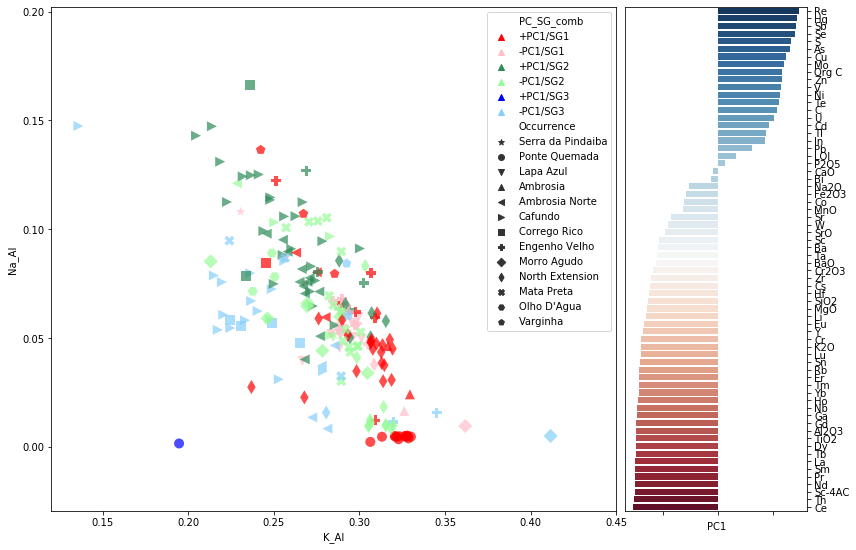

In [177]:
fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[:,:3])
f2_ax3 = fig.add_subplot(spec2[:,3])
#f2_ax4 = fig.add_subplot(spec2[1:,:3])

###PC Loadings
PC = 1

#####################################
i = PC -1
sns.barplot(x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False), y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, palette= 'RdBu_r', ax = f2_ax3)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax3.set_xticklabels(f2_ax3.get_xticklabels(), rotation=90)


sns.scatterplot(
    x='K_Al', 
    y = 'Na_Al', 
    data = data,
    hue = 'PC_SG_comb',
    hue_order = ['+PC1/SG1','-PC1/SG1', '+PC1/SG2', '-PC1/SG2',  '+PC1/SG3','-PC1/SG3'],
    palette= ['red','pink','seagreen','palegreen', 'blue', 'lightskyblue'],
    #palette = 'pastel',
    style = 'Occurrence', 
    markers=['*','o','v','^','<','>','s','P','D','d','X','H','p'], 
    s = 100,
    #size = 'PC1', 
    #sizes=(20,500), 
    alpha = 0.7,
    #ax = axes[1,1]
    edgecolor="none",
    ax = f2_ax2
)
f2_ax3.yaxis.tick_right()
f2_ax2.set_xlim(0.12,0.45)



plt.subplots_adjust(left=0.0, bottom=0.0, right=1.75, top=1.75, wspace=0.05, hspace=0.3)
plt.savefig('../02_Export/FIGURES/NaAl_KAl_PC1_Occurrence.png', bbox_inches="tight", dpi=300)

In [178]:
data_raw = pd.read_csv('../02_Export/CSV/DB_SG_ORIG_IMPUTTED_PCA.csv', index_col='Sample')

In [179]:
data_raw = data_raw.add_prefix('org_')

In [180]:
data = pd.concat([data, data_raw.loc[:,'org_Al2O3':'org_LOI']], axis = 1)

In [181]:
data['org_La_Th'] = data['org_La'] / data['org_Th']

In [182]:
data['Test_PC'] = np.nan
pc_visual = 'PC6'
data['Test_PC'] = np.where(data[pc_visual] <= 0,'-'+str(pc_visual),'+' + str(pc_visual))
data['PC_SG_comb'] = data.Test_PC.map(str) + "/" + data.Subunit
data['PC_SG_comb'].unique().tolist()

['+PC6/SG1', '-PC6/SG1', '+PC6/SG3', '+PC6/SG2', '-PC6/SG3', '-PC6/SG2']

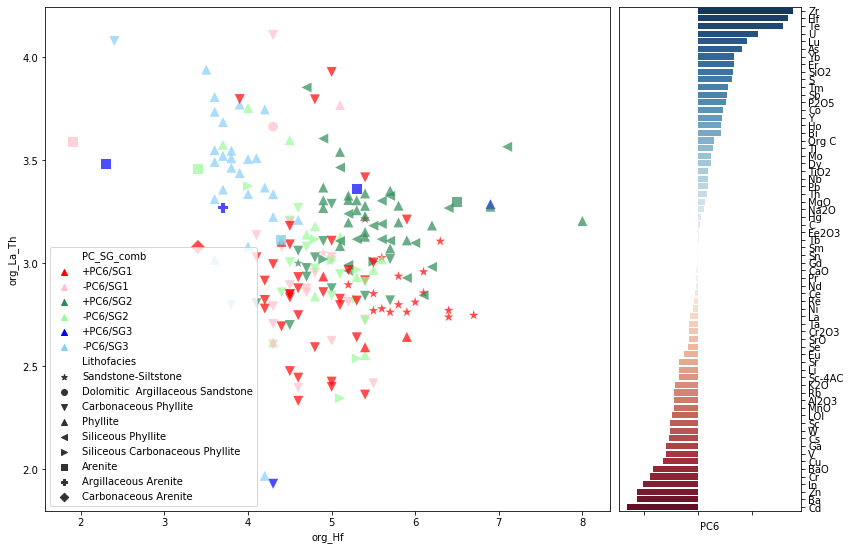

In [183]:
fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
#f2_ax1 = fig.add_subplot(spec2[0, 0])
f2_ax2 = fig.add_subplot(spec2[:,:3])
f2_ax3 = fig.add_subplot(spec2[:,3])
#f2_ax4 = fig.add_subplot(spec2[1:,:3])

###PC Loadings
PC = 6

#####################################
i = PC -1
sns.barplot(x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False), y = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, palette= 'RdBu_r', ax = f2_ax3)
#sns.lineplot(y = 0, x = sheet_dict[str(subgroup) + '_rotation']['PC' + str(i+1)].sort_values(ascending=False).index, color = 'black')
f2_ax3.set_xticklabels(f2_ax3.get_xticklabels(), rotation=90)


sns.scatterplot(
    x='org_Hf', 
    y = 'org_La_Th', 
    data = data,
    hue = 'PC_SG_comb',
    hue_order = ['+PC6/SG1','-PC6/SG1', '+PC6/SG2', '-PC6/SG2',  '+PC6/SG3','-PC6/SG3'],
    palette= ['red','pink','seagreen','palegreen', 'blue', 'lightskyblue'],
    #palette = 'pastel',
    style = 'Lithofacies', 
    markers=['*','o','v','^','<','>','s','P','D','d','X','H','p'], 
    s = 100,
    #size = 'PC6', 
    #sizes=(20,500), 
    alpha = 0.7,
    #ax = axes[1,1]
    edgecolor="none",
    ax = f2_ax2
)
f2_ax3.yaxis.tick_right()
#f2_ax2.set_xlim(0.12,0.45)



plt.subplots_adjust(left=0.0, bottom=0.0, right=1.75, top=1.75, wspace=0.05, hspace=0.3)
plt.savefig('../02_Export/FIGURES/LaTh_Hf_PC6_Lithofacies.png', bbox_inches="tight", dpi=300)